## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle

#### User Input Data


In [2]:
path_images = "D:\\Work\\Sarbazi\\data\\dataset"
path_masks = "D:\\Work\\Sarbazi\\data\\dataset\\manual segmentations"
batch_size = 4
femur_locator = True
if femur_locator:
    # for femur locator
    image_shape = (1024//2, 1024//2)
    crop_enabled = False
else:
    # for accurate segmentation
    image_shape = (1024//2, 768//2)
    crop_enabled = True

#### Data Generation


In [3]:
MyUtils = reload(MyUtils)
id_all_data = MyUtils.get_id_all_data(path_masks)
id_training_data, id_testing_data = MyUtils.split_train_test_id(id_all_data,testing_share=0.2)
training_data = MyUtils.DataGenerator(path_images, path_masks, id_training_data, batch_size, image_shape, crop_enabled, True, True)
testing_data = MyUtils.DataGenerator(path_images, path_masks, id_testing_data, 20, image_shape, crop_enabled, False, True)

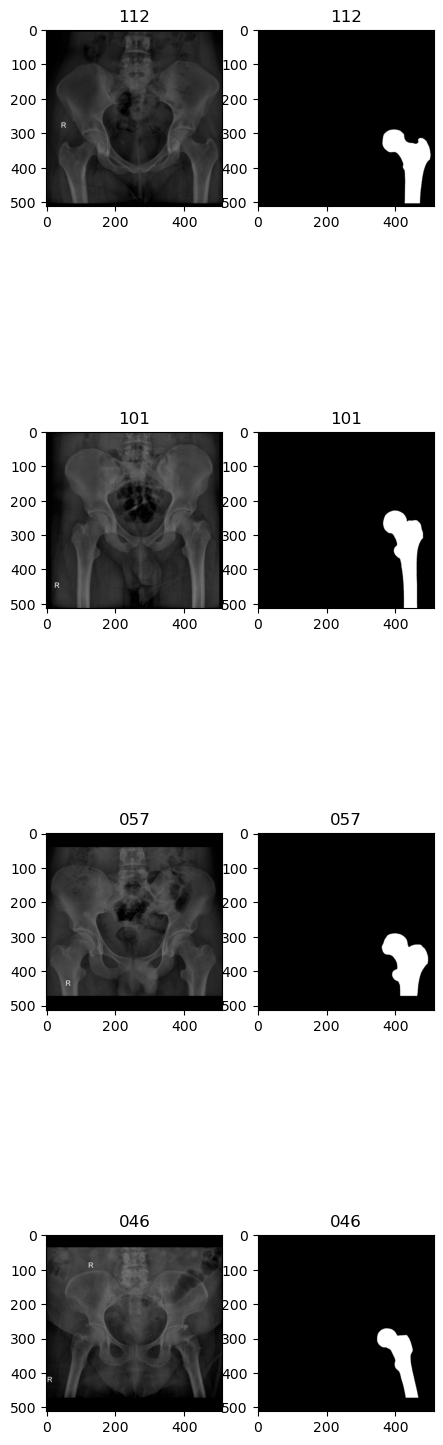

In [4]:
batch_id = 0
sample_batch_image, sample_batch_mask = training_data.__getitem__(batch_id)
img_ids = training_data._get_image_ids(batch_id)
fig, ax = plt.subplots(4, 2, figsize=(5, 20))
for i in range(batch_size):
    ax[i, 0].imshow(sample_batch_image[i,:,:,0],cmap='gray')
    ax[i, 0].set_title(str(img_ids[i]).zfill(3))
    ax[i, 1].imshow(sample_batch_mask[i,:,:,0],cmap='gray')
    ax[i, 1].set_title(str(img_ids[i]).zfill(3))

#### Create U-Net


In [5]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
if femur_locator:
    UNetModel = UNet.create_UNet_locator((*image_shape,1), (*image_shape,1))
else:
    UNetModel = UNet.create_UNet_accurate((*image_shape,1), (*image_shape,1))
UNetModel.compile(optimizer=MyUtils.keras.optimizers.Adam(), loss=MyUtils.keras.losses.BinaryCrossentropy(), metrics=[MyUtils.dice_coef, MyUtils.iou_coef, MyUtils.keras.metrics.BinaryAccuracy(), MyUtils.keras.metrics.Recall(), MyUtils.keras.metrics.Precision()])
# UNetModel.compile(optimizer="adam", loss=MyUtils.dice_coef_loss, metrics=[MyUtils.dice_coef])
# UNetModel.summary(line_length=120)

In [6]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=50, workers=10)

Epoch 1/50
20/20 [==============================] - 8s 155ms/step - loss: 0.5635 - dice_coef: 0.0793 - iou_coef: 0.0417 - binary_accuracy: 0.9338 - recall: 3.1237e-04 - precision: 0.0031 - val_loss: 0.3605 - val_dice_coef: 0.0762 - val_iou_coef: 0.0396 - val_binary_accuracy: 0.9367 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 1s 49ms/step - loss: 0.2657 - dice_coef: 0.0477 - iou_coef: 0.0246 - binary_accuracy: 0.9381 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2227 - val_dice_coef: 0.0542 - val_iou_coef: 0.0279 - val_binary_accuracy: 0.9366 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 1s 47ms/step - loss: 0.2082 - dice_coef: 0.0866 - iou_coef: 0.0456 - binary_accuracy: 0.9398 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.1782 - val_dice_coef: 0.1340 - val_iou_coef: 0.0719 - val_binary_accuracy: 0.9385 - val_recall: 0.0000e+00 - val_precisio

In [51]:
if femur_locator:
    UNetModel.save('UNetModel_locator.h5', save_traces=True)
else:
    UNetModel.save('UNetModel_accurate.h5', save_traces=True)

In [20]:
if femur_locator:
    UNetModel = UNet.keras_models.load_model('UNetModel_locator.h5', custom_objects={"dice_coef_loss": MyUtils.dice_coef_loss, "dice_coef": MyUtils.dice_coef})
else:
    UNetModel = UNet.keras_models.load_model('UNetModel_accurate.h5', custom_objects={"dice_coef_loss": MyUtils.dice_coef_loss, "dice_coef": MyUtils.dice_coef})

In [52]:
batch_id = 0
sample_test_image, sample_test_mask = testing_data.__getitem__(batch_id)
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.bool_)

1/1 [==============================] - 0s 215ms/step


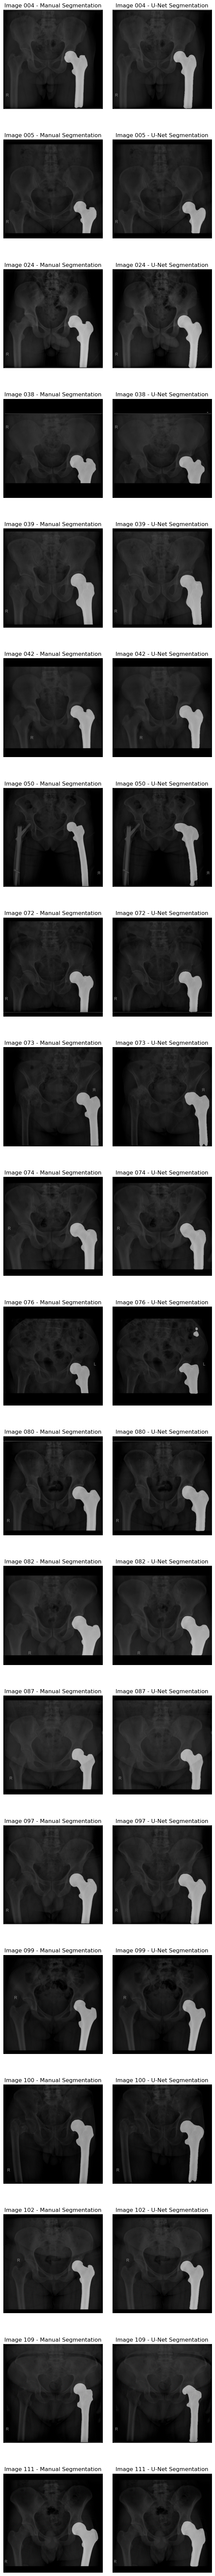

In [53]:
fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(8,100))
titles = [str(i).zfill(3) for i in testing_data._get_image_ids(batch_id)]
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,0].set_title("Image %s - Manual Segmentation" % (titles[i]))
    axs[i,0].axis('off')
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.5)
    axs[i,1].set_title("Image %s - U-Net Segmentation" % (titles[i]))
    axs[i,1].axis('off')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

In [38]:
with open('out.png','wb') as f:
    fig.savefig(f, dpi=600)